In [1]:
# import
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np 
from utils import *
from ADMM import *

/Users/jiqi/科研/工作2/Mixed-Graph-ADMM/ADMM.py:202: SyntaxWarning: invalid escape sequence '\V'
  '''


# 1 Load data

Data Disparity: compute standard error for each station (on the whole sequence) $\sigma_1,\dots, \sigma_N$
- Coefficient Variation (CV): $\text{CV} = {\text{std}(\sigma_1, \dots, \sigma_N)}/{\text{mean}(\sigma_1,\dots, \sigma_N)}$
- Variation: $\text{Var}=\text{Var}(\sigma_1, \dots, \sigma_N)$
- Range: $\text{PtP}=\max \sigma_i - \min \sigma_i$

Normalized Data: $\tilde{x} = (x - \min \mathbf{x}) / (\max \mathbf{x} - \min \mathbf{x})$, in (0, 1)

In [2]:
data_dir = '../datasets/PEMS0X_data'
# TODO: change here
dataset = 'PEMS04'
data_folder = os.path.join(data_dir, dataset)
data_file = dataset + '.npz'
graph_csv = dataset + '.csv'
# data
traffic_dataset = TrafficDataset(data_folder, data_file, graph_csv, transform='normalize')
print(f"data shape: {traffic_dataset.data.shape}, node number: {traffic_dataset.graph_info['n_nodes']}, edge number: {traffic_dataset.graph_info['n_edges']}")

# kNNs and graph construction
k = 4
nearest_nodes, nearest_dists = k_nearest_neighbors(traffic_dataset.graph_info['n_nodes'], traffic_dataset.graph_info['u_edges'], traffic_dataset.graph_info['u_dist'], k)
print(f'nearest nodes: {nearest_nodes.shape}, nearest_dists: {nearest_dists.shape}')

# mixed_graph_from_distance()

x, y = traffic_dataset.get_predict_data(0)
x, y = x.unsqueeze(0), y.unsqueeze(0)
print(f'recovering: x: {x.shape}, y: {y.shape}')

# difference in data
diff_x, diff_y = get_data_difference(x), get_data_difference(y)
print(f'difference: x: {diff_x.shape}, y: {diff_y.shape}')

# interpolation
interp_x, interp_y, mask = traffic_dataset.get_interpolated_data(0, 0.4)
interp_x, interp_y, mask = interp_x.unsqueeze(0), interp_y.unsqueeze(0), mask.unsqueeze(0)
print(f'interpolation: x: {interp_x.shape}, y: {interp_y.shape}, mask: {mask.shape}')

[Metric=std] Disparity of each station: CV: 0.3896, Var: 2198.0579, PtP: 221.3260
[Metric=iqr] Disparity of each station: CV: 0.4059, Var: 7313.3750, PtP: 436.0000
data shape: torch.Size([16992, 307, 1]), node number: 307, edge number: 340
307 nodes, 4 neighbors
nearest nodes: torch.Size([307, 5]), nearest_dists: torch.Size([307, 5])
recovering: x: torch.Size([1, 24, 307, 1]), y: torch.Size([1, 12, 307, 1])
difference: x: torch.Size([1, 23, 307, 1]), y: torch.Size([1, 11, 307, 1])
interpolation: x: torch.Size([1, 24, 307, 1]), y: torch.Size([1, 24, 307, 1]), mask: torch.Size([1, 24, 307, 1])


In [3]:
# Display disparity after normalization
cv, var, ptp = scalar_disparity(traffic_dataset.data, scale_metric='std')
print(f'[metric=std] coefficient of variation: {cv:.4f}, variance: {var:.4f}, peak-to-peak: {ptp:.4f}')
cv, var, ptp = scalar_disparity(traffic_dataset.data, scale_metric='iqr')
print(f'[metric=iqr] coefficient of variation: {cv:.4f}, variance: {var:.4f}, peak-to-peak: {ptp:.4f}')

[metric=std] coefficient of variation: 0.1536, variance: 0.0014, peak-to-peak: 0.2085
[metric=iqr] coefficient of variation: 0.2271, variance: 0.0093, peak-to-peak: 0.5112


# 2 Regression

Test regression result for neighbor of one node
- prediction
- difference
- interpolation

torch.Size([1, 24, 5, 1])


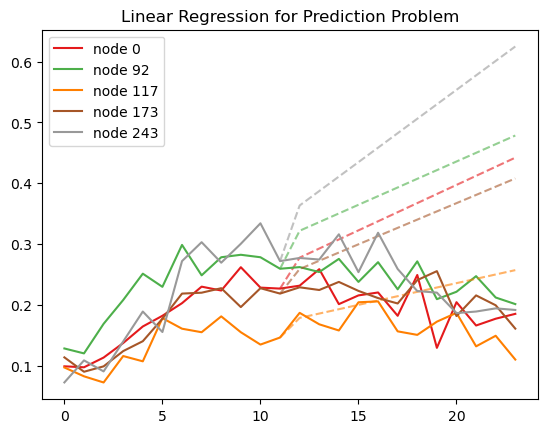

Linear regression: w torch.Size([1, 5, 1]), b torch.Size([1, 5, 1])
torch.Size([1, 24, 5, 1])


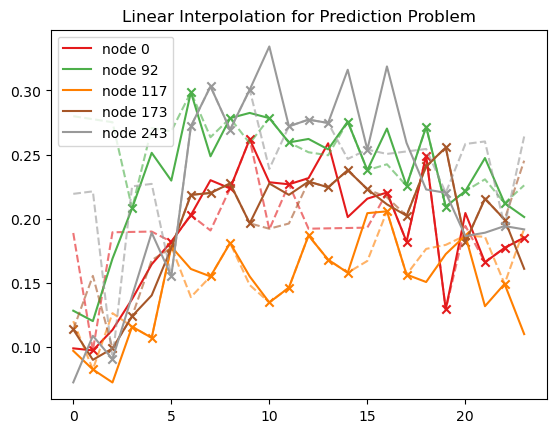

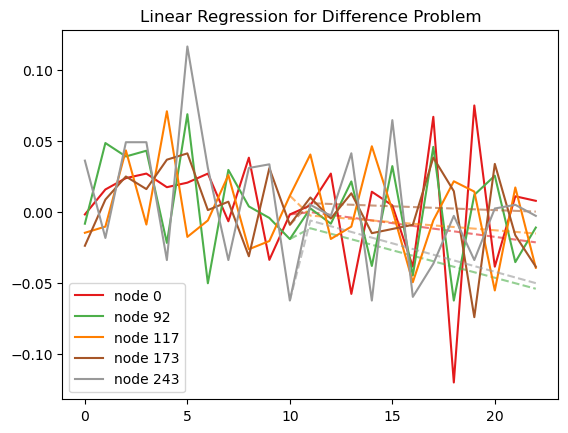

torch.Size([1, 24, 5, 1])


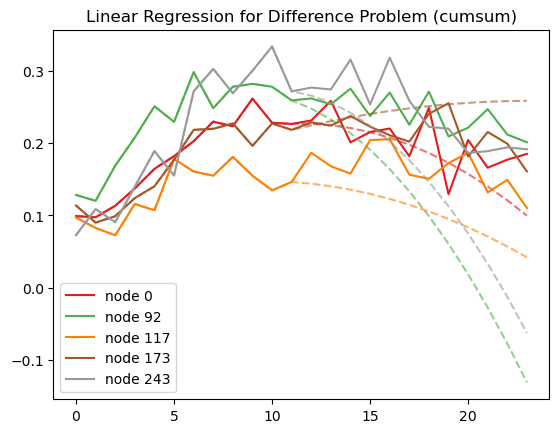

In [4]:
# take node 0 as an example
knn = nearest_nodes[0].to(torch.long) # [0. 92, 117, 173, 243]
# prediction
x_data = x[:,:,knn]
y_data = y[:,:,knn]
diff_x_data = diff_x[:,:,knn]
diff_y_data = diff_y[:,:,knn]
interp_x_data = interp_x[:,:,knn]
interp_y_data = interp_y[:,:,knn]
mask_data = mask[:,:,knn]

# linear regression
lr_y = initial_guess(y_data, 12, 24)
print(lr_y.shape)
t = torch.arange(0, 24, 1)
colors = plt.cm.Set1(np.linspace(0, 1, 5))

plt.figure()
for i, color in enumerate(colors):
    plt.plot(t, x_data.squeeze()[:,i], color=color, label=f'node {knn[i]}')
    plt.plot(t[11:], lr_y.squeeze()[11:,i], color=color, linestyle='--', alpha=0.6)
# plt.legend([f'node {i}' for i in knn])
plt.legend()
plt.title('Linear Regression for Prediction Problem')
plt.show()

# interpolation
lr_interp_y = initial_interpolation(interp_y_data, mask_data)
print(lr_interp_y.shape)
plt.figure()
for i, color in enumerate(colors):
    plt.plot(t, x_data.squeeze()[:,i], color=color, label=f'node {knn[i]}')
    plt.plot(t, lr_interp_y.squeeze()[:,i], color=color, linestyle='--', alpha=0.6)
    mask_i = mask_data.squeeze()[:,i].bool()

    # x_mask_i = x_data.squeeze()[mask.squeeze()[:,i] == 1, i]
    plt.scatter(t[mask_i], x_data.squeeze()[:,i][mask_i], color=color, marker='x')
# plt.legend([f'node {i}' for i in knn])
plt.legend()
plt.title('Linear Interpolation for Prediction Problem')
plt.show()

# difference
lr_diff_y = initial_guess(diff_y_data, 11, 23)
# t = torch.arange(0, 23, 1)
plt.figure()
for i, color in enumerate(colors):
    # plt.plot(t, x_data.squeeze()[:,i], color=color, label=f'node {knn[i]}')
    # plt.plot(t[11:], cumsum_y.squeeze()[11:,i], color=color, linestyle='--', alpha=0.6)
    plt.plot(t[:-1], diff_x_data.squeeze()[:,i], color=color, label=f'node {knn[i]}')
    plt.plot(t[10:-1], lr_diff_y.squeeze()[10:,i], color=color, linestyle='--', alpha=0.6)

plt.legend()
plt.title('Linear Regression for Difference Problem')
plt.show()

plt.figure()

# sum up
cumsum_y = torch.cumsum(lr_diff_y, dim=1) + y_data[:,:1]
cumsum_y = torch.cat((y_data[:,0:1], cumsum_y), dim=1)
print(cumsum_y.shape)
for i, color in enumerate(colors):
    # plt.plot(t, x_data.squeeze()[:,i], color=color, label=f'node {knn[i]}')
    # plt.plot(t[11:], cumsum_y.squeeze()[11:,i], color=color, linestyle='--', alpha=0.6)
    plt.plot(t, x_data.squeeze()[:,i], color=color, label=f'node {knn[i]}')
    plt.plot(t, cumsum_y.squeeze()[:,i], color=color, linestyle='--', alpha=0.6)

plt.legend()
plt.title('Linear Regression for Difference Problem (cumsum)')
plt.show()


# 3 ADMM algorithm

different graph types:
- undirected graph: kNN graph based on distance on each layer
- directed graphs:
    - line graphs
    - line graphs with skip connection

different data types:
- prediction
- interpolation
- difference

ablation studies:
- w/o DGTV
- w/o DGLR
- fully undirected graph

Residuals:

$$
\epsilon_{\text{pri}}^\tau(\mathbf{x}) = 

rho_init: 3.5765439556458225
307 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (3.2000, 2895.6001)
u_ew, d_ew shape torch.Size([24, 307, 4]) torch.Size([23, 307, 1])
ADMM iters 0: x_CG_iters 15, zu_CG_iters 12, zd_CG_iters 15, pri_err = [4.515, 2.898, 2.304], dual_err = [4.582, 2.896, 0.8859]
ADMM iters 1: x_CG_iters 17, zu_CG_iters 12, zd_CG_iters 16, pri_err = [0.4854, 1.71, 0.6316], dual_err = [1.331, 0.03747, 4.499]
ADMM iters 2: x_CG_iters 16, zu_CG_iters 12, zd_CG_iters 15, pri_err = [0.8366, 1.414, 0.2885], dual_err = [1.454, 0.03407, 2.225]
ADMM iters 3: x_CG_iters 16, zu_CG_iters 12, zd_CG_iters 15, pri_err = [0.8233, 1.239, 0.09574], dual_err = [1.43, 0.02519, 1.425]
ADMM iters 4: x_CG_iters 15, zu_CG_iters 12, zd_CG_iters 14, pri_err = [0.6443, 1.143, 0.05817], dual_err = [1.205, 0.02842, 1.079]
ADMM iters 5: x_CG_iters 15, zu_CG_iters 12, zd_CG_iters 14, pri_err = [0.4716, 1.067, 0.05341], dual_err = [1.003, 0.07374, 0.8985]
ADMM iters 6: x_CG_iters 15, z

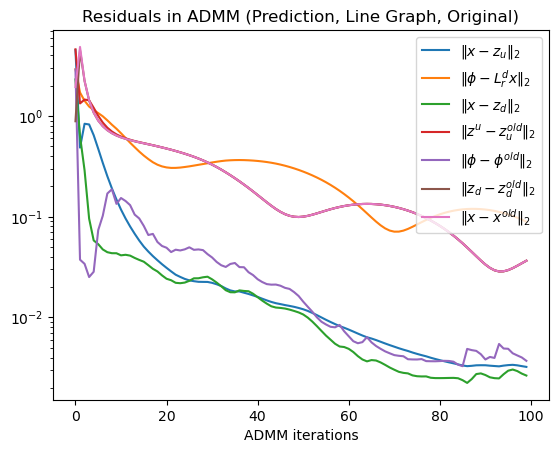

/Users/jiqi/科研/工作2/Mixed-Graph-ADMM/ADMM.py:548: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  dxps = torch.tensor([item.cpu().detach().numpy() for item in self.delta_x_per_step]) # in (L, 24)


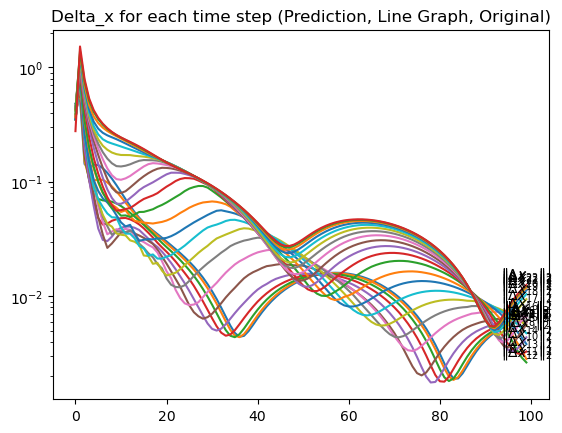

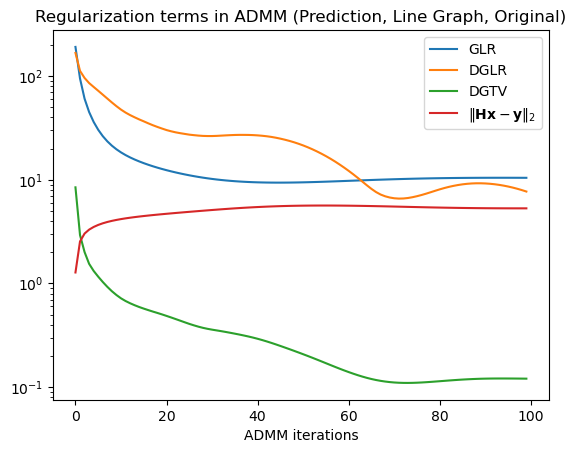

In [5]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 0.5
print('rho_init:', rho_init)
ADMM_info = {
    'rho': 4,
    'rho_u': 4,
    'rho_d': 4,
    'mu_u': 1,
    'mu_d1':1,
    'mu_d2': 1
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            use_line_graph=True
                            )
x_pred = admm_block.combined_loop(y)
admm_block.plot_residual(descriptions='Prediction, Line Graph, Original', log_y=True)
admm_block.plot_x_per_step(descriptions='Prediction, Line Graph, Original', log_y=True)
admm_block.plot_regularization_terms(descriptions='Prediction, Line Graph, Original', log_y=True)

Conclusion: DGTV is best minimized, which means $\mu_{d,1}$ requires smaller value than other params?

Other setting of ADMM parameters

In [ ]:
# use a grid search to find the best rho
# rho_list = [1, 2, 4, 8, 16, 32, 64]
# for rho in rho_list:
#     ADMM_info = {
#         'rho': rho,
#         'rho_u': rho,
#         'rho_d': rho,
#         'mu_u': 1,
#         'mu_d1':1,
#         'mu_d2': 1
#     }
#     admm_block = ADMM_algorithm(traffic_dataset.graph_info,
#                                 ADMM_info,
#                                 use_kNN=True,
#                                 k=4,
#                                 u_sigma=50,
#                                 d_sigma=50,
#                                 use_line_graph=True
#                                 )
#     x_pred = admm_block.combined_loop(y)
#     admm_block.plot_residual(descriptions=f'rho={rho}', log_y=True)
#   # admm_block.plot_x_per_step(descriptions=f'rho={rho}', log_y=True)
# #    admm_block.plot_regularization_terms(descriptions=f'rho={rho}', log_y=True)
#     print(f'rho: {rho}, residual: {admm_block.residual[-1]}')
#     print(f'rho: {rho}, x: {x_pred[-1]}')
#     print(f'rho: {rho}, y: {y}')
#     print(f'rho: {rho}, x-y: {x_pred[-1] - y}')


# Skip-connections

More complex line graphs


# Two-loop version

Problem in single loops: $\Vert z_u - z_u^{old}\Vert_2, \Vert z_d - z_d^{old}\Vert_2$ converge much slower than $\Vert x - x^{old}\Vert_2$.

Potential problems: all-in-one loop converges slower than multiple loops

Solve the linear equations first with restrictions $x=z_u=z_d$